In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from time import time

In [2]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [7]:
nb_classes = 9
batch_size = 64
nb_epoch = 1
np.random.seed(1337) # for reproducibility

In [4]:
features = joblib.load("./mldata/features_1200.mat")
labels = joblib.load("./mldata/lables_1200.mat")

features = np.array(features, 'int16')
labels = np.array(labels, 'int')

def scale(X, eps = 0.001):
    # scale the data points s.t the columns of the feature space
    # (i.e the predictors) are within the range [0, 1]
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) + eps)

features = features.astype("float32")
features = scale(features)

# scale the data to the range [0, 1] and then construct the training
# and testing splits
(trainX, testX, trainY, testY) = train_test_split(features, labels, test_size = 0.1)
(valX, testX, valY, testY) = train_test_split(testX, testY, test_size = 0.5)

# reshape for convolutions
trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
testX = testX.reshape((testX.shape[0], 1, 28, 28))
valX = valX.reshape((valX.shape[0], 1, 28, 28))

# convert class vectors to binary class matrices
trainY = np_utils.to_categorical(trainY, nb_classes)
testY = np_utils.to_categorical(testY, nb_classes)
valY = np_utils.to_categorical(valY, nb_classes)

In [13]:
# Creating the model which consists of 3 conv layers followed by
# 2 fully conntected layers

# Sequential wrapper model
model = Sequential()

# first convolutional layer
model.add(Convolution2D(32, 1, 2, 2))
model.add(Activation('relu'))

# second convolutional layer
model.add(Convolution2D(48, 32, 2, 2))
model.add(Activation('relu')) 
model.add(MaxPooling2D(poolsize=(2,2)))

# third convolutional layer
model.add(Convolution2D(32, 48, 2, 2))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(2,2)))

# convert convolutional filters to flatt so they can be feed to 
# fully connected layers
model.add(Flatten())

# first fully connected layer
model.add(Dense(32*6*6, 144, init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# second fully connected layer
model.add(Dense(144, 144, init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# last fully connected layer which output classes
model.add(Dense(144, 9, init='lecun_uniform'))
model.add(Activation('softmax'))

# setting sgd optimizer parameters
sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.fit(trainX, trainY,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          show_accuracy=True,
          verbose=1,
          validation_data=(testX, testY))

Train on 5400 samples, validate on 300 samples
Epoch 0
5400/5400 [==============================] - 217s - loss: 2.1737 - acc.: 0.1806 - val. loss: 2.0746 - val. acc.: 0.3401


{'acc': [0.18055555555555555],
 'epoch': [0],
 'loss': [2.173748743480314],
 'val_acc': [0.34005681818181815],
 'val_loss': [2.074591208852861]}

In [14]:
model.layers

In [33]:
for l in range(len(model.layers)):
    
    if model.layers[l].get_weights() != []:
        print l
        print model.layers[l]
#         print model.layers[l].get_weights()

0
2
5
9
12
15


In [47]:
model.layers[0].get_weights()[0].shape

(32, 1, 2, 2)

In [48]:
valX.shape

(300, 1, 28, 28)

In [60]:
valX[0].ravel().reshape(28,28)

(28, 28)

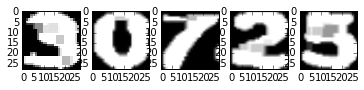

In [61]:
sample_0 = valX[0].ravel().reshape(28,28)
sample_1 = valX[1].ravel().reshape(28,28)
sample_2 = valX[2].ravel().reshape(28,28)
sample_3 = valX[3].ravel().reshape(28,28)
sample_4 = valX[4].ravel().reshape(28,28)

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
ax0.imshow(sample_0, cmap='gray', interpolation='nearest')
ax1.imshow(sample_1, cmap='gray')
ax2.imshow(sample_2, cmap='gray')
ax3.imshow(sample_3, cmap='gray')
ax4.imshow(sample_4, cmap='gray')

In [49]:
model1 = Sequential()
model1.add(Convolution2D(32, 1, 2, 2, weights=model.layers[0].get_weights()))
model1.add(Activation('relu'))
model1.compile(loss='categorical_crossentropy', optimizer=sgd)

In [62]:
valX_h_1 = model1.predict(valX)

300/300 [==============================] - 0s     


In [65]:
valX_h_1.shape

(300, 32, 27, 27)

In [67]:
valX_h_1[0][0].shape

(27, 27)

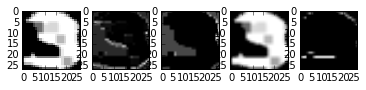

In [68]:
sample_0 = valX_h_1[0][0]
sample_1 = valX_h_1[0][1]
sample_2 = valX_h_1[0][2]
sample_3 = valX_h_1[0][3]
sample_4 = valX_h_1[0][4]

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
ax0.imshow(sample_0, cmap='gray', interpolation='nearest')
ax1.imshow(sample_1, cmap='gray')
ax2.imshow(sample_2, cmap='gray')
ax3.imshow(sample_3, cmap='gray')
ax4.imshow(sample_4, cmap='gray')

In [69]:
model2 = Sequential()
model2.add(Convolution2D(48, 32, 2, 2, weights=model.layers[2].get_weights()))
model2.add(Activation('relu'))
model2.compile(loss='categorical_crossentropy', optimizer=sgd)

In [78]:
valX_h_2 = model2.predict(valX_h_1)

300/300 [==============================] - 2s     


In [79]:
valX_h_2.shape

(300, 48, 26, 26)

In [80]:
valX_h_2[0][0].shape

(26, 26)

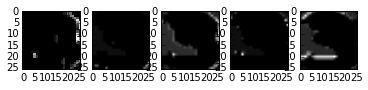

In [81]:
sample_0 = valX_h_2[0][0]
sample_1 = valX_h_2[0][1]
sample_2 = valX_h_2[0][2]
sample_3 = valX_h_2[0][3]
sample_4 = valX_h_2[0][4]

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
ax0.imshow(sample_0, cmap='gray', interpolation='nearest')
ax1.imshow(sample_1, cmap='gray')
ax2.imshow(sample_2, cmap='gray')
ax3.imshow(sample_3, cmap='gray')
ax4.imshow(sample_4, cmap='gray')

In [76]:
model3 = Sequential()
model3.add(Convolution2D(32, 48, 2, 2, weights=model.layers[5].get_weights()))
model3.add(Activation('relu'))
model3.compile(loss='categorical_crossentropy', optimizer=sgd)

In [82]:
valX_h_3 = model3.predict(valX_h_2)

300/300 [==============================] - 2s     


In [83]:
valX_h_3.shape

(300, 32, 25, 25)

In [84]:
valX_h_3[0][0].shape

(25, 25)

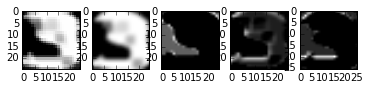

In [85]:
sample_0 = valX_h_3[0][0]
sample_1 = valX_h_3[0][1]
sample_2 = valX_h_3[0][2]
sample_3 = valX_h_3[0][3]
sample_4 = valX_h_2[0][4]

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
ax0.imshow(sample_0, cmap='gray', interpolation='nearest')
ax1.imshow(sample_1, cmap='gray')
ax2.imshow(sample_2, cmap='gray')
ax3.imshow(sample_3, cmap='gray')
ax4.imshow(sample_4, cmap='gray')